In [16]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import openpyxl
from openpyxl import Workbook
import json
import folium
from folium import features
import vincent
import shapefile
from json import dumps
import random
import pandas as pd
import geojson
import plotly.express as px
import pandas as pd
import numpy as np
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import folium
import branca
from folium.plugins import BeautifyIcon


month_to_number = {"Jan": 1, "Feb":2 , "Mar":3 , "Apr":4, "May": 5, "Jun":6, "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12}
def get_html_table(url):
	html_content = requests.get(url).text
	soup = BeautifulSoup(html_content, "html.parser")
	table = soup.find_all("table", class_="table table-bordered table-hover cc_cursor")
	return table
    
def table_to_df(table_data, headings):
	data = []
	for row in table_data:
		row_data = row.find_all('td')
		sub_data =[]
		for cell in row_data:
			entry = cell.text
			sub_data.append(entry)
		data.append(sub_data)

	df = pd.DataFrame(data, columns=headings)
	
	return df

def get_river_flow_data():
	url="http://www.wapda.gov.pk/index.php/river-flow-data"
	table = get_html_table(url)
	
	table_data = table[0].find_all('tr')
	table_data = table_data[4:]
	Headings = ['Date', 'Indus_levels','Indus at Tarbela (m3/s)','Indus_Outflow','Kabul at Nowshera (m3/s)',
	'Jhelum_levels','Jhelum at Mangla (m3/s)','Jhelum_Outflow', 'Chenab at Marala (m3/s)','System_Inflow_now',
	'System_Inflow_past','System_Inflow_avg']
	df = table_to_df(table_data,headings = Headings)
	df.drop(['Indus_levels', 'Indus_Outflow', 'Jhelum_levels', 'Jhelum_Outflow', 'System_Inflow_now', 'System_Inflow_past', 'System_Inflow_avg'], axis = 1, inplace = True)
	return df, table[0]


# Retrieving, organizing, and cleaning the data fetched


master_df, table = get_river_flow_data()
row = list(table.find_all('tr')[1])
row.remove('\n')
period= row[0]
period = period.text
starting_period, ending_period = period[::-1][0:7][::-1].split('-')[0],"20" + period[::-1][0:7][::-1].split('-')[1]

master_df['Date'] = master_df['Date'].apply(lambda date: date.replace('-', ' ')).apply(lambda date: date.replace('/', ' ')).apply(lambda date: date[:len(date)-1])
master_df = master_df[::-1].reset_index(drop = True, inplace = False)
master_df[['Day','Month']] = master_df['Date'].str.split(' ',expand=True)
master_df['Month'] = master_df['Month'].apply(lambda month: 'Nov' if (month == 'No') else ("Aug" if month == 'Au' else month))
years_list = []
curr = starting_period 
months = master_df['Month']
# print(list(set(months)))
prev = "init"
for month in months: 
    if prev == "Dec" and month == "Jan": 
        curr = ending_period 
    years_list.append(curr)
    prev = month

master_df["Year"] = years_list




master_df["Month"] = master_df["Month"].apply(lambda month: month_to_number[month])
master_df["Date"] = pd.to_datetime(master_df[["Year", "Month", "Day"]])
master_df = master_df[['Date', 'Indus at Tarbela (m3/s)','Kabul at Nowshera (m3/s)','Jhelum at Mangla (m3/s)','Chenab at Marala (m3/s)']]

for data_col in list(master_df.columns)[1:]:
	master_df[data_col] = master_df[data_col].apply(lambda data: data.strip())

In [17]:

m1 = folium.Map(location=(32, 67), #location sets the longitude and latitude of the map
              zoom_start=4, tiles='Stamen Terrain')
plotting_data = {
    "Indus": {
        "location": "Tarbela", 
        "coords": [34.088961, 72.697154], 
        "shapefile": 'UIB/UIB_30m_New.shp', 
        "fillColor" : '#1F51FF', 
        "border_color" : '#1F51FF'
        }, 
    "Kabul":{
        "location": "Nowshera", 
        "coords": [34.0105, 71.9876], 
        "shapefile": 'Kabul/krbshape.shp', 
        "fillColor": '#7f00ff', 
        "border_color" : '#7f00ff'
        }, 
    "Jhelum": {
        "location": "Mangla", 
        "coords": [33.0947, 73.6418], 
        "shapefile": 'mangla/newmangla.shp', 
        "fillColor": 'yellow', 
        "border_color" : 'yellow'
        },
    "Chenab":{
        "location": "Marala", 
        "coords":[32.7772, 73.8779], 
        "shapefile": 'chenab/newchenab.shp', 
        "fillColor": 'red', 
        "border_color" : 'firebrick'
        }, 

}

# Generating the html plots 

for river in plotting_data.keys(): 

    col_name = "{} at {} (m3/s)".format(river, plotting_data[river]["location"])
    shpfile = plotting_data[river]["shapefile"]

    df = master_df[["Date", col_name]]
    df[col_name] = pd.to_numeric(df[col_name], downcast="float")
    fig=make_subplots(specs=[[{"secondary_y":True}]])
    fig.add_trace(                           
        go.Scatter(
        x=df['Date'],
        y=df[col_name],
        mode='lines',                  
        line = dict(color='firebrick', width=3)
        )
    )
    
    fig.update_layout(hoverlabel_bgcolor='#DAEEED',  #Change the background color of the tooltip to light gray
                #title_text="Housing Market Trends: Atlanta, GA", #Add a chart title
                title_font_family="Times New Roman",
                title_font_size = 20,
                title_font_color="darkblue", #Specify font color of the title
                title_x=0.5, #Specify the title position
                xaxis_title='Date'     ,
                yaxis_title=col_name,
                )

    plot_name = "Timeseries Plots/{}.html".format(river)
    fig.write_html(plot_name)

    html_list=[]
    html_list.append(plot_name)
    df2=pd.DataFrame(html_list,columns =['html_file'])
    #df2


    icon_circle = BeautifyIcon(
        icon_shape='circle-dot', 
        border_color=plotting_data[river]["border_color"], 
        border_width=6,
    )

    for i in range(0,len(html_list)):
        html="""
        <iframe src=\"""" + df2['html_file'][i] + """\" width="600" height="300"  frameborder="0">    
        """
        popup = folium.Popup(folium.Html(html, script=True))
        folium.Marker( location=plotting_data[river]["coords"],tooltip=plotting_data[river]["location"], icon=icon_circle,
                    popup=popup,).add_to(m1)
    



    reader = shapefile.Reader(shpfile)
    fields = reader.fields[1:]
    field_names = [field[0] for field in fields]
    buffer = []
    for sr in reader.shapeRecords():
        atr = dict(zip(field_names, sr.record))
        geom = sr.shape.__geo_interface__
        buffer.append(dict(type="Feature",     geometry=geom, properties=atr)) 

    json_name = "{}.json".format(river)
    #writing the GEOJson file
    geojson = open(json_name.format(river), "w") #this file is saved in the current working directory
    geojson.write(dumps({"type": "FeatureCollection","features": buffer}, indent=2) + "\n")
    geojson.close()


    style = {'fillColor': plotting_data[river]["fillColor"]}    
    polygon = folium.GeoJson(json_name, style_function = lambda x: style).add_to(m1)



m1.save("Final plot.html")

<ipython-input-17-cd66427dd5cc>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name] = pd.to_numeric(df[col_name], downcast="float")
<ipython-input-17-cd66427dd5cc>:43: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
source_code = open("Timeseries Plots/indus.html", 'r', encoding= 'utf-8').read()
text_file = open("sample.html", "w")
n = text_file.write(source_code)
text_file.close()
print(type(source_code))

<class 'str'>


In [14]:
import pandas as pd

plot_name = "Timeseries Plots/indus.html"

html_list=[]
html_list.append(plot_name)
df2=pd.DataFrame(html_list,columns = ['html_file'])
df2['html_file'][0]

'Timeseries Plots/indus.html'

matplotlib.axes._subplots.AxesSubplot

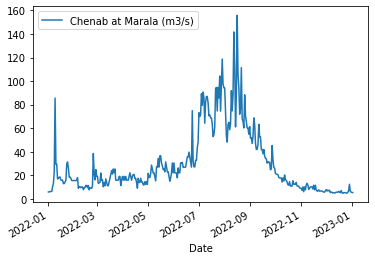

In [21]:
type(df.plot(x="Date"))